In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from matplotlib.pyplot import grid
from scipy.stats import alpha

## TO DO LIST
1.

In [26]:
path = os.path.join('../../Data/Combined/master.geojson')
data = gpd.read_file(path)
pathm = os.path.join('../../Data/Metro/Metros_Ground_Transfer.geojson')
metro = gpd.read_file(pathm)
#data.head()

In [27]:
data.columns

Index(['ccn', 'report_dat', 'start_date', 'end_date', 'block', 'offense',
       'method', 'shift', 'ward', 'anc', 'district', 'psa',
       'neighborhood_cluster', 'block_group', 'census_tract',
       'voting_precinct', 'bid', 'xblock', 'yblock', 'latitude', 'longitude',
       'objectid', 'octo_record_id', 'crime_type', 'auto_crime',
       'nearest_station_id', 'distance_meters', 'distance_manhattan',
       'nearest_station_name', 'above_ground', 'transfer_station', 'geoid',
       'name', 'total_population', 'total_housing_units',
       'median_household_income', 'poverty_rate', 'unemployment_rate',
       'pct_bachelors_or_higher', 'pct_renter_occupied', 'vacancy_rate',
       'pct_non_hispanic_black', 'pct_hispanic_latino', 'geometry'],
      dtype='object')

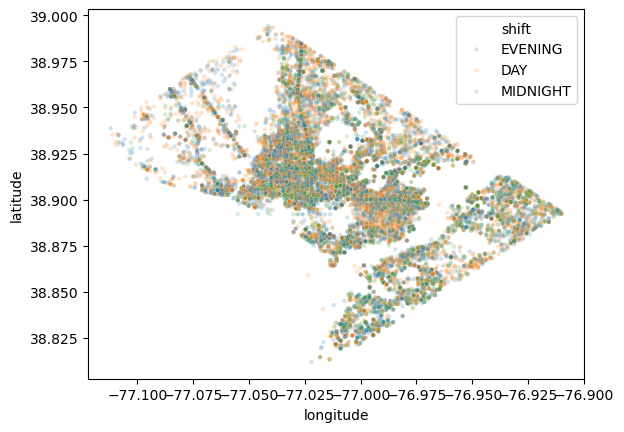

In [28]:
sns.scatterplot(data=data,
                x='longitude',
                y='latitude',
                hue='shift',
                alpha = 0.2,
                s=10)
plt.show()

In [29]:
conditions = [
    data['auto_crime'] == 1,
    data['crime_type'] == 'violent',
    (data['crime_type'] == 'property') & (data['auto_crime'] == 0)
]

choices = [
    'car_related',
    'violent',
    'property'
]

data['crime'] = np.select(conditions, choices, default=None)

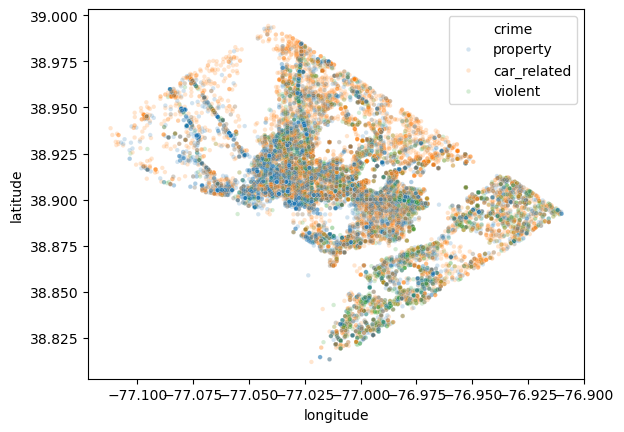

In [30]:
sns.scatterplot(data=data,
                x='longitude',
                y='latitude',
                hue='crime',
                alpha = 0.2,
                s=10)
plt.show()

In [31]:
#metro.head()
metro["lon"] = metro.geometry.x
metro["lat"] = metro.geometry.y


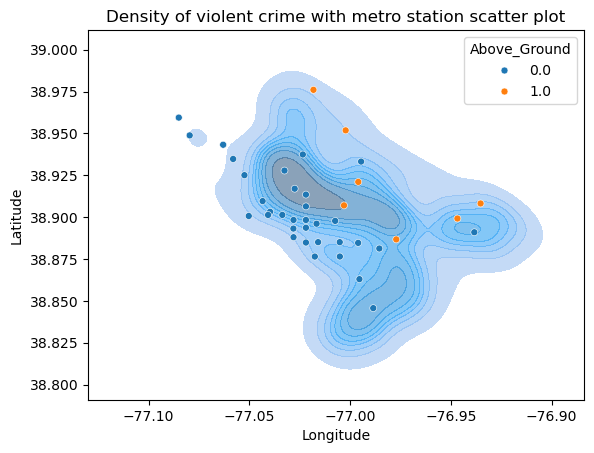

In [32]:
sns.kdeplot(data=data[data['crime'] == 'violent'], # switch out for 'car_related', 'violent' or 'property'
            x='longitude',
            y='latitude',
            fill=True,
            hue='crime', # 'SHIFT'
            alpha = 0.6)
# overlay metro stations
sns.scatterplot(data=metro,
                x= 'lon',
                y= 'lat',
                s=25,
                hue='Above_Ground')
plt.title('Density of violent crime with metro station scatter plot')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

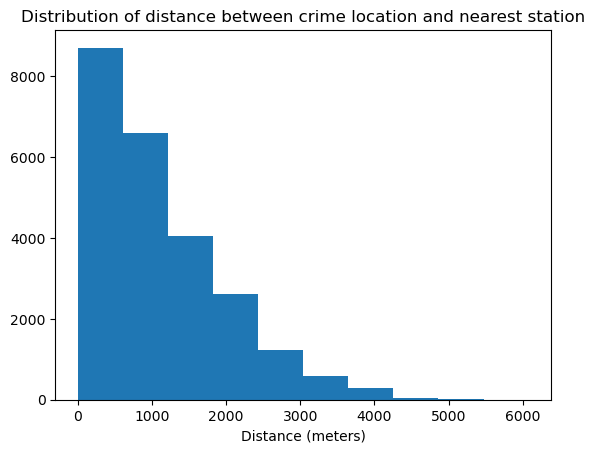

In [33]:
plt.hist(data=data, x='distance_meters')
plt.xlabel('Distance (meters)')
plt.title('Distribution of distance between crime location and nearest station')
plt.show()

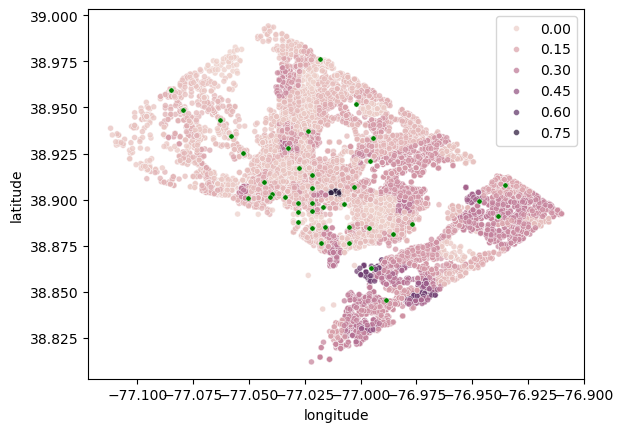

In [34]:
sns.scatterplot(data=data,
                x='longitude',
                y='latitude',
                hue='poverty_rate',
                s= 18,
                alpha = 0.75)
sns.scatterplot(data=metro,
                x= 'lon',
                y= 'lat',
                s=14,
                color='green')
plt.show()

In [35]:
data['violent_crime'] = np.where(data['crime_type'] == 'violent', 1, 0)


In [36]:
X = data[['median_household_income', 'poverty_rate', 'unemployment_rate', 'pct_bachelors_or_higher',  'vacancy_rate', 'pct_hispanic_latino', 'latitude', 'longitude', 'auto_crime']]
X = X.dropna()
y = X['auto_crime']
X = X.drop(columns=['auto_crime'])

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=4810
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression()
model.fit(X_train_scaled, y_train)

print(f'Coefficients: {model.coef_}')
print(f'Intercepts: {model.intercept_}')

y_prob = model.predict_proba(X_test_scaled)[:,1]
y_pred = model.predict(X_test_scaled)

#accuracy_score(y_test, y_pred)
#confusion_matrix(y_test, y_pred)

print(roc_auc_score(y_test, y_prob))


Coefficients: [[ 0.2442454  -0.10457946 -0.11655    -0.3900673  -0.13136543 -0.10494332
   0.16454399  0.24950478]]
Intercepts: [-0.51896984]
0.6256383139501714


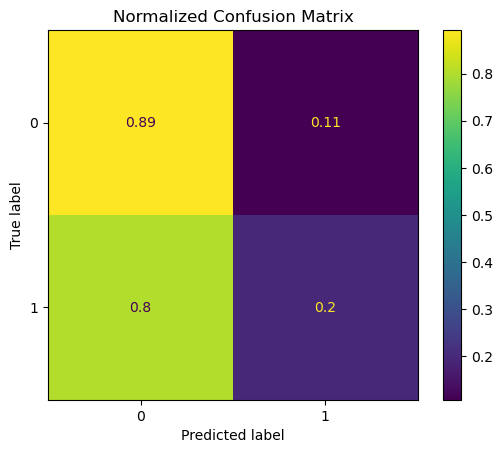

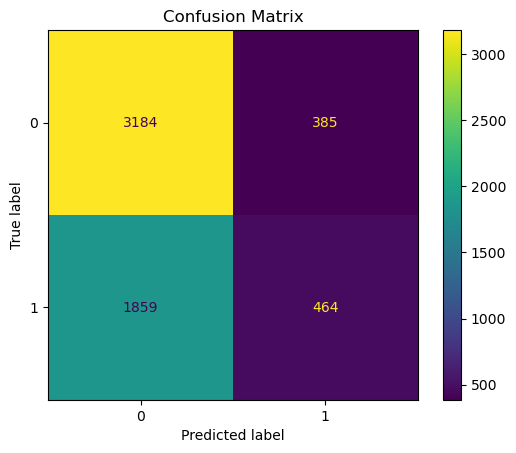

In [37]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp_norm.plot()
plt.title("Normalized Confusion Matrix")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')

plt.show()